# Notebook for visualizing attention layers during inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/MScAI/Year01/5_CV2/point_e_team10/layout-guidance'
!pip install -r requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/MScAI/Year01/5_CV2/point_e_team10/layout-guidance
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-077i_n0x
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-077i_n0x
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 109.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from typing import Union, Tuple, List, Callable, Dict, Optional
from IPython.display import Image, display
from tqdm import tqdm

from PIL import Image
from omegaconf import OmegaConf
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, LMSDiscreteScheduler
from my_model import unet_2d_condition

from utils import compute_ca_loss, Pharse2idx, draw_box, setup_logger
from hydra import compose, initialize
from natsort import natsorted

import os
import abc
import csv
import torch
import json
import numpy as np
import pandas as pd
import seaborn  as sns 
import matplotlib.pyplot as plt
import imageio

### Code for running inference

In [ ]:
def inference(device, unet, vae, tokenizer, text_encoder, prompt, bboxes, phrases, cfg, logger, save_timestep = True, save_iter = False):
    if save_timestep or save_iter:
      save_path = './pickle/prompt_0'
      
      counter = 1
      while os.path.exists(save_path):
        save_path = './pickle/prompt_' + str(counter)
        counter += 1
      os.makedirs(save_path)
    
    with open('attentionmap.csv', 'a') as file:
        column_id = ['TimeStep','AttentionUp', 'AttentionMid', 'AttentionDown']
        writer = csv.writer(file)
        writer.writerow(column_id)
        file.close()
    
    logger.info("Inference")
    logger.info(f"Prompt: {prompt}")
    logger.info(f"Phrases: {phrases}")

    # Get Object Positions
    logger.info("Conver Phrases to Object Positions")
    object_positions = Pharse2idx(prompt, phrases)

    # Encode Classifier Embeddings
    uncond_input = tokenizer(
        [""] * cfg.inference.batch_size, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Encode Prompt
    input_ids = tokenizer(
            [prompt] * cfg.inference.batch_size,
            padding="max_length",
            truncation=True,
            max_length=tokenizer.model_max_length,
            return_tensors="pt",
        )

    cond_embeddings = text_encoder(input_ids.input_ids.to(device))[0]
    text_embeddings = torch.cat([uncond_embeddings, cond_embeddings])
    generator = torch.manual_seed(cfg.inference.rand_seed)  # Seed generator to create the inital latent noise

    
    latents = torch.randn(
        (cfg.inference.batch_size, 4, 64, 64),
        generator=generator,
    ).to(device)

    noise_scheduler = LMSDiscreteScheduler(beta_start=cfg.noise_schedule.beta_start, beta_end=cfg.noise_schedule.beta_end,
                                           beta_schedule=cfg.noise_schedule.beta_schedule, num_train_timesteps=cfg.noise_schedule.num_train_timesteps)

    noise_scheduler.set_timesteps(cfg.inference.timesteps)

    latents = latents * noise_scheduler.init_noise_sigma

    loss = torch.tensor(10000)

    for index, t in enumerate(tqdm(noise_scheduler.timesteps)):
        iteration = 0

        while loss.item() / cfg.inference.loss_scale > cfg.inference.loss_threshold and iteration < cfg.inference.max_iter and index < cfg.inference.max_index_step:
            latents = latents.requires_grad_(True)
            latent_model_input = latents
            latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)
            noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down = \
                unet(latent_model_input, t, encoder_hidden_states=cond_embeddings)
           
            # save attn_map before latents update
            if save_iter:
              attn_dict = {"up":attn_map_integrated_up, "mid":attn_map_integrated_mid, "down":attn_map_integrated_down}
              torch.save(attn_dict, "{}/attn_timestep_{}_iteration_{}.pt".format(save_path, index, iteration))

            # update latents with guidance
            loss = compute_ca_loss(attn_map_integrated_mid, attn_map_integrated_up, bboxes=bboxes,
                                   object_positions=object_positions) * cfg.inference.loss_scale

            grad_cond = torch.autograd.grad(loss.requires_grad_(True), [latents])[0]

            latents = latents - grad_cond * noise_scheduler.sigmas[index] ** 2
            iteration += 1
            torch.cuda.empty_cache()

        with torch.no_grad():
            latent_model_input = torch.cat([latents] * 2)

            latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)
            noise_pred, attn_map_integrated_up, attn_map_integrated_mid, attn_map_integrated_down = \
                unet(latent_model_input, t, encoder_hidden_states=text_embeddings)

            # Save final timestep attn_map 
            if save_timestep:
              attn_dict = {"up":attn_map_integrated_up, "mid":attn_map_integrated_mid, "down":attn_map_integrated_down}
              torch.save(attn_dict, "{}/attn_timestep_{}.pt".format(save_path, index))
              
            noise_pred = noise_pred.sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + cfg.inference.classifier_free_guidance * (noise_pred_text - noise_pred_uncond)

            latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
            torch.cuda.empty_cache()

    with torch.no_grad():
        logger.info("Decode Image...")
        latents = 1 / 0.18215 * latents
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]

        return pil_images, uncond_input, uncond_embeddings, input_ids, cond_embeddings

### Helper functions for visualizing attentionmaps

In [ ]:
def itercheck(path, timestep, iteration):
  return os.path.isfile('{}/attn_timestep_{}_iteration_{}.pt'.format(path, timestep,iteration))

def load_pt(path, timestep, iteration=None):
  if iteration != None:
    pt = torch.load('{}/attn_timestep_{}_iteration_{}.pt'.format(path, timestep, iteration))
  else:
    pt = torch.load('{}/attn_timestep_{}.pt'.format(path, timestep))

  return pt

def average_heads(map, token, iterations=False):
  b, i, _ = map.shape
  h = w = int(np.sqrt(i))
  map = map[:,:,token].reshape(b,h,w)
  if iterations:
    map = map.to('cpu')
    map_np = map.detach().numpy()
    avg_map = np.mean(map_np, axis=0)
  else:
    avg_map = torch.mean(map, dim=0)
    avg_map = avg_map.cpu().numpy()
  return avg_map

def average_blocks(map, token, iterations=False):
  avg_heads = []
  for block in range(len(map)):
    avg_heads.append(average_heads(map[block], token, iterations))

  return np.mean(avg_heads, axis=0)

def plt_map(save_path, map, token, timestep, iteration, inference=False):
  plt.figure()
  if inference:
    plt.title('Token:{}, Timestep:{}, Iteration:_'.format(token, timestep))
  else:
    plt.title('Token:{}, Timestep:{}, Iteration:{}'.format(token, timestep, iteration))

  sns.heatmap(map, cmap='rocket_r', vmin=0, vmax=0.07);

  os.makedirs('{}/token_{}'.format(save_path, token), exist_ok=True)
  plt.savefig('{}/token_{}/{}_{}.png'.format(save_path, token, timestep, iteration))
  plt.close()


def visualize_attn_maps(path, cfg, prompt_num, token_num, iterations=False, conv_block='up', cross_attn_block=0):
  """ Visualize selected attentionmaps per timestep (and iteration) and compile them into a gif
  
  Args: 
    path (str): Path to folder of saved attentionmaps
    cfg (Omegaconf): Composed configuration file
    prompt_num (int): Number corresponding to the inference prompt
    token_num (int): Number of tokens obtained from prompt
    iterations (bool, optional): Whether to visualize the maps inbetween iterations per timestep. Defaults to False.
    conv_block (str, optional): Selected U-Net sampling convolution block. Defaults to 'up'.
    cross_attn_block (int, optional): Selected cross-attention block. Defaults to 0.
  """
  # Folder where we want to save visualizations
  vis_path = './attention_vis/prompt_{}/{}_attn_maps'.format(prompt_num, conv_block)
  os.makedirs(vis_path, exist_ok=True)

  for token in range(token_num):
    print('Token: {}'.format(token))
    for timestep in tqdm(range(cfg.inference.timesteps)):
      # Map inbetween iterations of single timestep
      if iterations:
        for iter in range(cfg.inference.max_iter):
          # Check if there was any latent update during this iteration
          if itercheck(path, timestep, iter):
            pt = load_pt(path, timestep, iter)
            if conv_block == 'mid':
              avg_map = average_heads(pt[conv_block][0], token, iterations)
            else:
              avg_map = average_blocks(pt[conv_block][cross_attn_block], token, iterations)
            # Plot and save visualization
            plt_map(vis_path, avg_map, token, timestep, iter)

      # Map at end of timestep
      pt = load_pt(path, timestep)
      if conv_block == 'mid':
        avg_map = average_heads(pt[conv_block][0], token)
      else:
        avg_map = average_blocks(pt[conv_block][cross_attn_block], token)
      plt_map(vis_path, avg_map, token, timestep, iteration = cfg.inference.max_iter, inference=True)

      # Compile gif
      im_path = vis_path + '/token_' + str(token)
      files = [os.path.join(im_path, file) for file in natsorted(os.listdir(im_path))]
      images = [imageio.imread(file) for file in files]

      gif_path = vis_path + '/gif'
      os.makedirs(gif_path, exist_ok=True)
      imageio.mimsave('{}/token_{}.gif'.format(gif_path, token), images, fps=4)

        


In [ ]:
# vis_path = './attention_vis/prompt_0/up_attn_maps'
# for token in range(12):
#   im_path = vis_path + '/token_' + str(token)
#   files = [os.path.join(im_path, file) for file in natsorted(os.listdir(im_path))]
#   images = [imageio.imread(file) for file in files]

#   gif_path = vis_path + '/gif'
#   os.makedirs(gif_path, exist_ok=True)
#   imageio.mimsave('{}/token_{}.gif'.format(gif_path, token), images, fps=3)

### Prepare Model

In [ ]:
# Compose configuration file
initialize(config_path="conf")
cfg = compose(config_name="base_config")

# Build model
with open(cfg.general.unet_config) as f:
    unet_config = json.load(f)
unet = unet_2d_condition.UNet2DConditionModel(**unet_config).from_pretrained(cfg.general.model_path, subfolder="unet")
tokenizer = CLIPTokenizer.from_pretrained(cfg.general.model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(cfg.general.model_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(cfg.general.model_path, subfolder="vae")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet.to(device)
text_encoder.to(device)
vae.to(device)

# Prepare the save path
if not os.path.exists(cfg.general.save_path):
    os.makedirs(cfg.general.save_path)
logger = setup_logger(cfg.general.save_path, __name__)

logger.info(cfg)
# Save cfg
logger.info("save config to {}".format(os.path.join(cfg.general.save_path, 'config.yaml')))
OmegaConf.save(cfg, os.path.join(cfg.general.save_path, 'config.yaml'))



<ipython-input-6-a339b91abec5>:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="conf")


INFO:__main__:{'general': {'save_path': './example_output', 'model_path': 'runwayml/stable-diffusion-v1-5', 'unet_config': './conf/unet/config.json'}, 'inference': {'loss_scale': 30, 'batch_size': 1, 'loss_threshold': 0.2, 'max_iter': 5, 'max_index_step': 10, 'timesteps': 51, 'classifier_free_guidance': 7.5, 'rand_seed': 445}, 'noise_schedule': {'beta_start': 0.00085, 'beta_end': 0.012, 'beta_schedule': 'scaled_linear', 'num_train_timesteps': 1000}}
INFO:__main__:save config to ./example_output/config.yaml


### Start Prompt-to-Image

In [ ]:
# Prompt
examples = {"prompt": "A hello kitty toy is playing with a purple ball.",
            "phrases": "hello kitty; ball",
            "bboxes": [[[0.1, 0.2, 0.5, 0.8]], [[0.75, 0.6, 0.95, 0.8]]],
            'save_path': cfg.general.save_path
            }

# Inference
pil_images, uncond_input, uncond_embeddings, input_ids, cond_embeddings = inference(device, unet, vae, tokenizer, text_encoder, examples['prompt'], examples['bboxes'], examples['phrases'], cfg, logger)

### Visualize Attentionmaps


First upsampling block (resolution: 16x16)

In [ ]:
path = './pickle/prompt_0'
visualize_attn_maps(path, cfg, prompt_num=0, token_num = 13, iterations=True, conv_block='up', cross_attn_block=2)

Token: 0


100%|██████████| 51/51 [09:43<00:00, 11.45s/it]


Token: 1


100%|██████████| 51/51 [05:01<00:00,  5.91s/it]


Token: 2


100%|██████████| 51/51 [04:55<00:00,  5.80s/it]


Token: 3


100%|██████████| 51/51 [04:56<00:00,  5.82s/it]


Token: 4


100%|██████████| 51/51 [04:54<00:00,  5.78s/it]


Token: 5


100%|██████████| 51/51 [04:53<00:00,  5.75s/it]


Token: 6


100%|██████████| 51/51 [04:49<00:00,  5.68s/it]


Token: 7


100%|██████████| 51/51 [04:50<00:00,  5.70s/it]


Token: 8


100%|██████████| 51/51 [04:43<00:00,  5.56s/it]


Token: 9


100%|██████████| 51/51 [04:46<00:00,  5.62s/it]


Token: 10


100%|██████████| 51/51 [04:46<00:00,  5.61s/it]


Token: 11


100%|██████████| 51/51 [04:45<00:00,  5.60s/it]


Token: 12


100%|██████████| 51/51 [04:40<00:00,  5.50s/it]


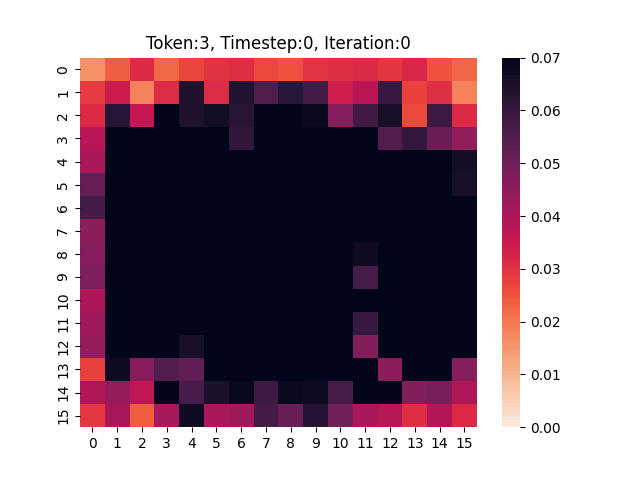

In [ ]:
from IPython.display import Image, display
def display_gif(filename):
    display(Image(filename=filename, format='png'))

# Display the three GIFs
display_gif('./attention_vis/up_attn_maps/token_3/3.gif')
